In [1]:
from keras import backend as K
import keras
from keras.callbacks import EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau,Callback
from keras.optimizers import Adam
K.set_image_data_format('channels_first')
from fr_utils import *
import keras
from generator_utils import *
ALPHA = 0.1
THRESHOLD = 0.5
#IMAGE_SIZE = 96
IMAGE_SIZE = 224
LAYERS_TO_FREEZE = 60
NUM_EPOCHS = 100
STEPS_PER_EPOCH = 30
BATCH_SIZE = 64

Using TensorFlow backend.
100%|██████████| 716/716 [00:21<00:00, 33.10it/s]


In [2]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
def triplet_loss(y_true, y_pred, alpha=ALPHA):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    return loss

In [4]:
model_path = 'Saved Model/tripletmodelVGG.h5'
from keras.layers import *
if  os.path.exists(model_path):
    print("Pre trained model found")
    FRmodel = keras.models.load_model(model_path, custom_objects={'triplet_loss': triplet_loss})

else:
    print('Saved model not found, loading untrained FaceNet')
    #FRmodel = faceRecoModel(input_shape=(3, IMAGE_SIZE, IMAGE_SIZE))
    #load_weights_from_FaceNet(FRmodel)
    X_input = Input((3, IMAGE_SIZE, IMAGE_SIZE))
    model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=X_input)
    print(len(model.layers))
    for layer in model.layers:
        layer.trainable = False
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu')(x)
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    FRmodel = Model(inputs = X_input, outputs = X, name='FaceRecoModel')

#for layer in FRmodel.layers[0: LAYERS_TO_FREEZE]:
#    layer.trainable = False

W0208 15:20:30.964904 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0208 15:20:30.995078 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0208 15:20:31.003870 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0208 15:20:31.021841 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprec

Saved model not found, loading untrained FaceNet


W0208 15:20:32.053534 139668578576192 deprecation.py:506] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


19


In [5]:
input_shape = (3, IMAGE_SIZE, IMAGE_SIZE)
A = Input(shape=input_shape, name='anchor')
P = Input(shape=input_shape, name='anchorPositive')
N = Input(shape=input_shape, name='anchorNegative')

enc_A = FRmodel(A)
enc_P = FRmodel(P)
enc_N = FRmodel(N)
optimizer = Adam(lr=0.01, epsilon=1e-08, decay=0.0) 
# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='FaceRecoModel_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
checkpoint_dir = 'Saved Model/Tensorboard/'
tensorboard = TensorBoard(log_dir=checkpoint_dir + 'TripletModel')
# Model
tripletModel = Model(inputs=[A, P, N], outputs=[enc_A, enc_P, enc_N])
tripletModel.compile(optimizer=optimizer, loss=triplet_loss)

gen = batch_generator(BATCH_SIZE)

W0208 15:20:33.846889 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [6]:
#history=tripletModel.fit_generator(gen, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,callbacks=[learning_rate_reduction,tensorboard])
history=tripletModel.fit_generator(gen, epochs=50, steps_per_epoch=10,callbacks=[learning_rate_reduction,tensorboard])
FRmodel.save(model_path)

W0208 15:20:34.088977 139668578576192 deprecation.py:323] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0208 15:20:36.295812 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0208 15:20:36.297902 139668578576192 deprecation_wrapper.py:119] From /home/span/acad/akabir/myproject1/lib/python3.6/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/50
10/10 [==============================] - 156s 16s/step - loss: 0.2943 - FaceRecoModel_loss: 0.0914
Epoch 2/50
10/10 [==============================] - 152s 15s/step - loss: 0.2779 - FaceRecoModel_loss: 0.0955
Epoch 3/50
10/10 [==============================] - 152s 15s/step - loss: 0.2969 - FaceRecoModel_loss: 0.0969
Epoch 4/50
10/10 [==============================] - 153s 15s/step - loss: 0.2664 - FaceRecoModel_loss: 0.0995
Epoch 5/50
10/10 [==============================] - 153s 15s/step - loss: 0.3100 - FaceRecoModel_loss: 0.1108
Epoch 6/50
10/10 [==============================] - 154s 15s/step - loss: 0.2989 - FaceRecoModel_loss: 0.0850
Epoch 7/50
10/10 [==============================] - 152s 15s/step - loss: 0.3080 - FaceRecoModel_loss: 0.1109
Epoch 8/50
10/10 [==============================] - 154s 15s/step - loss: 0.3688 - FaceRecoModel_loss: 0.1297
Epoch 9/50
10/10 [==============================] - 152s 15s/step - loss: 0.3049 - FaceRecoModel_loss: 0.1099
Epoch 10/5

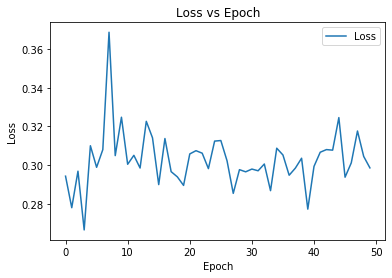

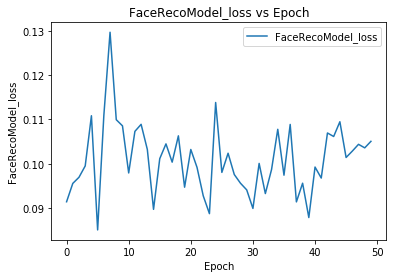

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper right')
plt.savefig('loss.png')
plt.show()

plt.plot(history.history['FaceRecoModel_loss'])
plt.title('FaceRecoModel_loss vs Epoch')
plt.ylabel('FaceRecoModel_loss')
plt.xlabel('Epoch')
plt.legend(['FaceRecoModel_loss'], loc='upper right')
plt.savefig('FaceRecoModel_loss.png')
plt.show()